#EDA and Clustering project

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#let's try some SQL code to see how it works in python
!pip install pandasql
from pandasql import sqldf



  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=3d07973d8f04e5fdc94975e721c54e6d8ca4ecf394644cdba81611dbe3a14650
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [3]:
#import the dataset
path='//content/drive/MyDrive/DataSets'
df=pd.read_csv(path+'/uk_ecommerce.csv',sep=',',encoding='latin-1')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,7-Dec-17,4.95,12680.0,France,NaN


In [ ]:
#let's see what the data looks like
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [4]:
#Let's add and additional column with the total revenue for purchase
df['Total_Revenue']=df['Quantity']*df['UnitPrice']

In [ ]:
#Let´s see the NaN or null values in the df and evaluate if they affect the EDA or the clustering
df.isna().sum()

InvoiceNo             0
StockCode             0
Description        1454
Quantity              0
InvoiceDate           0
UnitPrice             0
CustomerID       135080
Country               0
Unnamed: 8       541909
Total_Revenue         0
dtype: int64

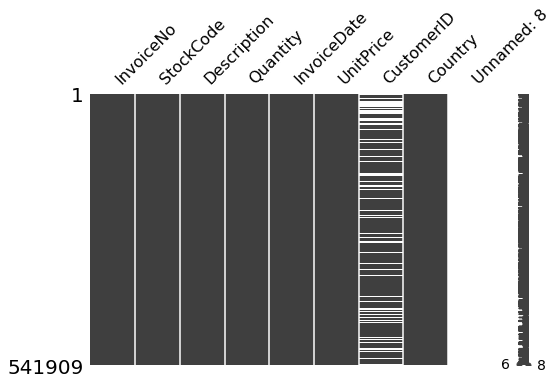

In [ ]:
msno.matrix(df,figsize=(8,5))

In [5]:
#Droped the empty column 'Unnamed:8', NaN values in 'Description' column and any row with 0 values on it.
df.drop(columns=['Unnamed: 8'], inplace=True)
df=df[df['Description'].notna()]



#EDA
* What was the total revenue?
* In which months the sales were higher?
* What products are the top 5 in sales and revenue?
* Which products were returne more frequently?
* What is the top 10 countries that purchesed the most?
* What is the share of revenue for each cluster?

In [ ]:
#For EDA, I created a new df with NaN values in customerID filled with 0. The reason is that for EDA we are interested in what data can tell us about the sales.
#For clustering we haver to drop this empty customerID as we'll analyze purchases per customer
df_eda=df.fillna(0)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,16.60


In [ ]:
#What was the total revenue?
Sum_revenue=df_eda.Total_Revenue.sum()
print ('Total Revenue:\n','$ ', round(Sum_revenue,2))

Total Revenue:
 $  9747747.93


In [ ]:
#In which months the sales were higher?

#let's separate the year and month
import datetime as dt
df_eda['InvoiceDate']=pd.to_datetime(df_eda['InvoiceDate'])

df_eda['Month']=df_eda['InvoiceDate'].dt.month
df_eda['Year']=df_eda['InvoiceDate'].dt.year

In [ ]:
#total purchases per year
by_month=df_eda.groupby(df_eda['InvoiceDate'].dt.year).count().InvoiceDate
by_month

InvoiceDate
2016     42481
2017    499428
Name: InvoiceDate, dtype: int64

In [ ]:
Total_per_month=df_eda.groupby(['Year','Month'])['Total_Revenue'].sum()
Total_per_month

Year  Month
2016  11        104842.840
      12        644114.180
2017  1         609481.930
      2         492349.140
      3         663890.700
      4         475780.001
      5         769062.060
      6         651601.730
      7         704438.401
      8         725412.070
      9         952269.532
      10       1133061.700
      11       1496272.650
      12        325171.000
Name: Total_Revenue, dtype: float64

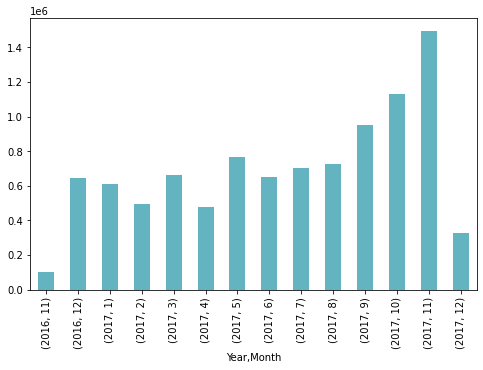

In [ ]:
Total_per_month.plot(kind='bar', color='#63b3c0',figsize=(8,5))

In [ ]:
#What products are the top 5 in sales? 
Top_products=df_eda[['StockCode','Description','Quantity','Total_Revenue']].groupby(['StockCode','Description'],as_index=False).sum(['Quantity','Total_Revenue']).sort_values(by='Quantity',ascending=False)
#WE have to exclude the rows with no stockcode
Top_products=Top_products[Top_products['StockCode'].str.contains('^[1-9]')]
Top_products.head()

,StockCode,Description,Quantity,Total_Revenue
3135,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847,13587.93
3633,85099B,JUMBO BAG RED RETROSPOT,47359,92356.03
3424,84879,ASSORTED COLOUR BIRD ORNAMENT,36381,58959.73
1132,22197,POPCORN HOLDER,36334,33969.46
449,21212,PACK OF 72 RETROSPOT CAKE CASES,36039,21059.72


In [ ]:
#Let´s see the top 5 in revenue, let's exclude 
Top_revenue=Top_products.sort_values(by='Total_Revenue', ascending=False)
Top_revenue.head(5)

,StockCode,Description,Quantity,Total_Revenue
1343,22423,REGENCY CAKESTAND 3 TIER,13022,164762.19
2882,47566,PARTY BUNTING,18018,98302.98
3654,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35021,97715.99
3633,85099B,JUMBO BAG RED RETROSPOT,47359,92356.03
2032,23084,RABBIT NIGHT LIGHT,30680,66756.59


Text(0.5, 1.0, 'Top 5 products in revenue')

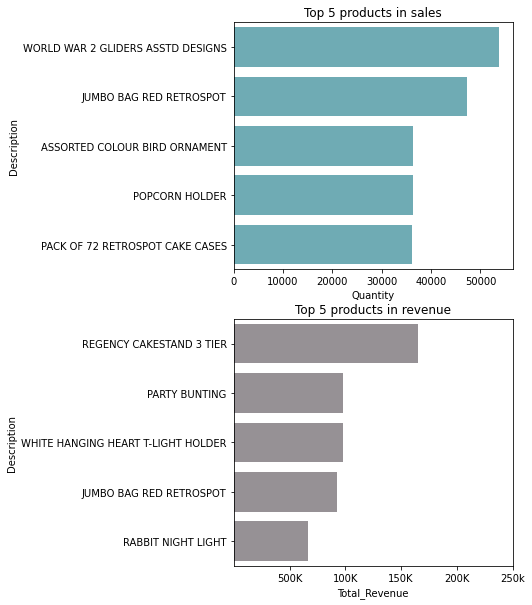

In [ ]:
f, axis=plt.subplots(2,1,figsize=(5,10))
ax2=sns.barplot(x='Quantity', y='Description', data=Top_products.head(5), color='#63b3c0',ax=axis[0]).set(title='Top 5 products in sales')


ax3=sns.barplot(x='Total_Revenue',y='Description', data=Top_revenue.head(5), color='#979095',ax=axis[1])
ax3.set_xticks([50000, 100000, 150000, 200000,250000])
ax3.set_xticklabels(['500K','100K','150K','200K','250k'])
plt.title('Top 5 products in revenue')


In [ ]:
#Let's create a df with the products with negative revenue
df_loss=df_eda[['StockCode','Description','Quantity','Total_Revenue']].loc[df_eda['Total_Revenue']<0].sort_values(by='Total_Revenue', ascending=True)

#We need only the products
df_loss=df_loss[df_loss['StockCode'].str.contains('^[1-9]')]
df_loss.groupby(['StockCode','Description'], as_index=False).sum().sort_values(by='Quantity')


,StockCode,Description,Quantity,Total_Revenue
1529,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,-168469.60
1270,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74494,-77479.64
1688,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9376,-321.60
133,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3150,-6591.42
96,20971,PINK BLUE FELT CRAFT TRINKET BOX,-2617,-2778.77
...,...,...,...,...
1463,23419,HOME SWEET HOME BOTTLE,-1,-2.08
1793,84971S,SMALL HEART FLOWERS HOOK,-1,-0.85
1458,23411,TRELLIS COAT RACK,-1,-4.95
166,21201,TROPICAL HONEYCOMB PAPER GARLAND,-1,-2.55


[Text(0, 0, '0'),
 Text(0, 0, '-20k'),
 Text(0, 0, '-40K'),
 Text(0, 0, '-60k'),
 Text(0, 0, '-80k'),
 Text(0, 0, '-100k')]

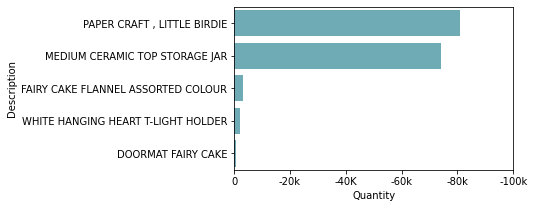

In [ ]:
#Let's see the top 5 returnet products
f, axis=plt.subplots(figsize=(5,3))
ax4=sns.barplot(x='Quantity',y='Description',data=df_loss.head(5),color='#63b3c0')
plt.gca().invert_xaxis()
ax4.set_xticks([0,-20000,-40000,-60000,-80000,-100000])
ax4.set_xticklabels(['0','-20k','-40K','-60k','-80k','-100k'])

In [ ]:
#What was the total loss
df_loss.sum()

StockCode        23843231662110885123A48185231132117547566B2219...
Description      PAPER CRAFT , LITTLE BIRDIEMEDIUM CERAMIC TOP ...
Quantity                                                   -272030
Total_Revenue                                              -478724
dtype: object

In [ ]:
#What is the top 5 countries that purchesed the most?
df_countries=df_eda[['Country','Quantity','Total_Revenue']].groupby(['Country'],as_index=False).sum().sort_values(by='Quantity',ascending=False)
df_countries.head()

,Country,Quantity,Total_Revenue
36,United Kingdom,4399359,8.187806e+06
24,Netherlands,199552,2.846615e+05
10,EIRE,142363,2.632768e+05
14,Germany,117446,2.216982e+05
13,France,110479,1.974039e+05


In [ ]:
top_countries=df_countries.head(10).sort_values('Total_Revenue', ascending=False)
top_countries['Revenue_%']=top_countries['Total_Revenue']/9747747.93
top_countries

,Country,Quantity,Total_Revenue,Revenue_%
36,United Kingdom,4399359,8.187806e+06,0.839969
24,Netherlands,199552,2.846615e+05,0.029203
10,EIRE,142363,2.632768e+05,0.027009
14,Germany,117446,2.216982e+05,0.022744
13,France,110479,1.974039e+05,0.020251
0,Australia,83345,1.370773e+05,0.014062
33,Switzerland,30324,5.638535e+04,0.005784
31,Spain,26813,5.477458e+04,0.005619
32,Sweden,35637,3.659591e+04,0.003754
20,Japan,25218,3.534062e+04,0.003626


Text(0.5, 1.0, 'Top 10 countries that purchase the most')

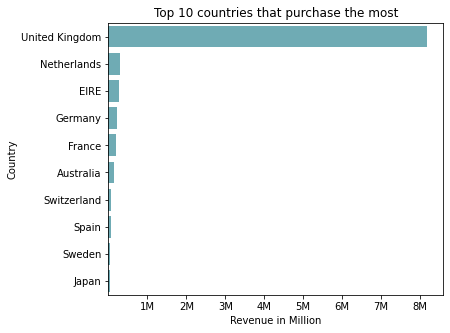

In [ ]:
fig, axis=plt.subplots(1,1,figsize=(6,5))
ax1=sns.barplot(y='Country', x='Total_Revenue', data=top_countries, color='#63b3c0')
ax1.set_xticks([1000000,2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000])
ax1.set_xticklabels(['1M','2M','3M','4M','5M','6M','7M','8M'])
plt.xlabel('Revenue in Million')
plt.title('Top 10 countries that purchase the most')

In [ ]:
#What is the share of revenue for each cluster?
#To answer this question
df_share=df_clustering[['cluster_km','Total_Revenue']].groupby(['cluster_km'],as_index=False).sum().sort_values(by='Total_Revenue',ascending=False)

In [ ]:
#Let's calculate the share % for each cluster
df_share['share (%)']=df_share['Total_Revenue']/[df_share['Total_Revenue'].sum()]*100
df_share['share (%)']=df_share['share (%)'].round(2)

In [ ]:
#Let's see how many clients have each cluster
df_share['Total_clients']=df_clustering['cluster_km'].value_counts()
df_share

,cluster_km,Total_Revenue,share (%),Total_clients
2,2,3634531.76,49.75,4007
0,0,2354147.91,32.22,320
1,1,935592.31,12.81,25
3,3,381700.18,5.22,5


In [ ]:
#We can represent all these shares in a pie chart

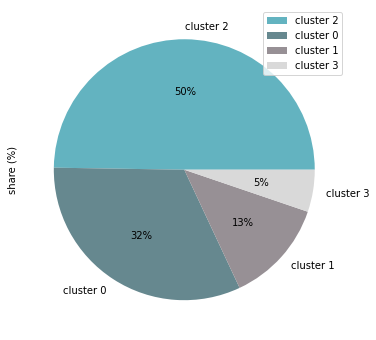

In [ ]:
colors=['#63b3c0','#66888f','#979095','#d9d9d9']
sns.set_palette(sns.color_palette(colors))
df_share.plot.pie(y='share (%)', figsize=(6,6), labels=['cluster 2','cluster 0','cluster 1','cluster 3'],autopct='%.0f%%')

#Clustering algorithm

For clustering, we need to identify customers with similar purchases behavior and then group them into clusters. 
* identify the number of customer segments
* Find the customers who are hightly valued

In [6]:
#For clustering, we need to drop the rows with no product code (Amazon fee, postage, bank charges, and others). There are 2933 rows to drop.
df_products=df[df['StockCode'].str.contains('^[1-9]')]

In [7]:
#let's group the purchases by customer
df_sales=sqldf("SELECT CustomerID, COUNTRY, COUNT(InvoiceNo) AS Total_purchases, SUM(Total_Revenue) as Total_Revenue, SUM(Quantity) as Quantity FROM df_products GROUP BY CustomerID ORDER BY Quantity desc;")
df_sales.head()

,CustomerID,Country,Total_purchases,Total_Revenue,Quantity
0,NaN,United Kingdom,132566,1505647.11,282492
1,14646.0,Netherlands,2066,278778.02,197132
2,12415.0,Australia,776,123638.18,77242
3,14911.0,EIRE,5813,128882.13,77098
4,17450.0,United Kingdom,340,189735.53,69041


In [9]:
#For clustering, we need to drop all the missing values from the df, 
#We need to find the significant customers for the business, so purchases with no CustomerID are useless
df_sales.dropna(inplace=True)

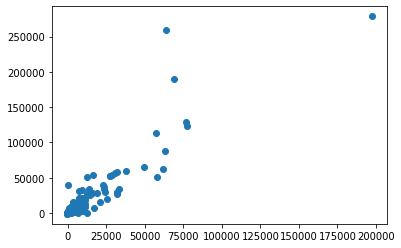

In [10]:
#now, let's see how the data is distributed
plt.scatter(df_sales['Quantity'], df_sales['Total_Revenue'])

Text(0.5, 1.0, 'Quantity vs Revenue per client')

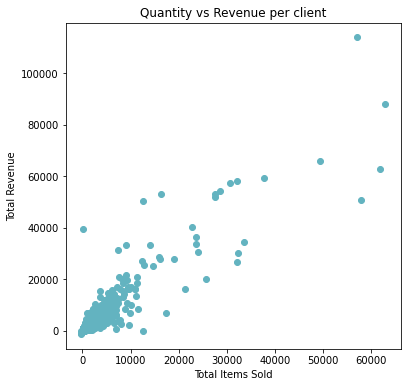

In [11]:
#Here we can see outliers, to better indentify the cluster centers, we need to set limits to the top values of Total_revenue and Quantity
df_clustering=sqldf("SELECT CustomerID,	Total_purchases,	Total_Revenue,	Quantity FROM df_sales WHERE Total_Revenue <150000 and Quantity <70000")
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(df_clustering['Quantity'], df_clustering['Total_Revenue'], color=('#63b3c0'))
plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Quantity vs Revenue per client')

##Scaling using minmax scaler

In [12]:
scaler=MinMaxScaler()
scaler.fit(df_clustering[['Quantity']])
df_clustering['Quantity_scaled']=scaler.transform(df_clustering[['Quantity']])

scaler.fit(df_clustering[['Total_Revenue']])
df_clustering['Revenue_scaled']=scaler.transform(df_clustering[['Total_Revenue']])
df_clustering.head()

,CustomerID,Total_purchases,Total_Revenue,Quantity,Quantity_scaled,Revenue_scaled
0,17511.0,1074,88138.20,63014,1.000000,0.776465
1,13694.0,582,62924.10,61808,0.980953,0.557303
2,14298.0,1640,50862.44,58021,0.921143,0.452462
3,14156.0,1406,113855.32,57013,0.905223,1.000000
4,16684.0,280,65920.12,49391,0.784845,0.583344


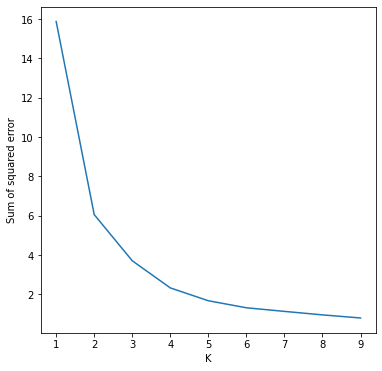

In [13]:
#Now we need to find the k-clusters. Let's use the Elbow method to find them
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_clustering[['Quantity_scaled','Revenue_scaled']])
    sse.append(km.inertia_)

fig, axes = plt.subplots(1,1,figsize=(6,6))
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

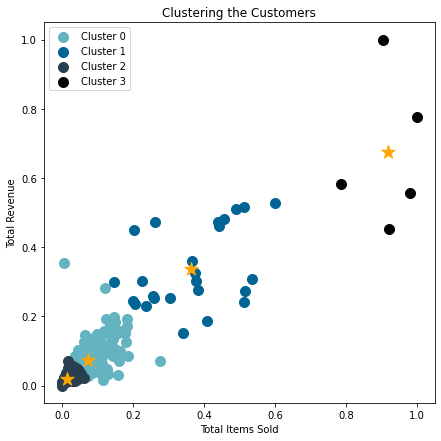

In [ ]:
#Let's trye Kmean method with the scaled data
km=KMeans(n_clusters=4)
points=df_clustering[['Quantity_scaled','Revenue_scaled']].to_numpy()
y_km=km.fit_predict(points)

fig, axes = plt.subplots(1,1,figsize=(7,7))
Cluster_0=plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='#63b3c0')
Cluster_1=plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='#006494')
Cluster_2=plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='#293f4e')
Cluster_3=plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='#020300')


plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='orange',marker='*',label='centroid',s=200)
plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')
plt.legend([Cluster_0,Cluster_1,Cluster_2,Cluster_3],['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])

##other methods

Text(0.5, 1.0, 'Clustering the Customers')

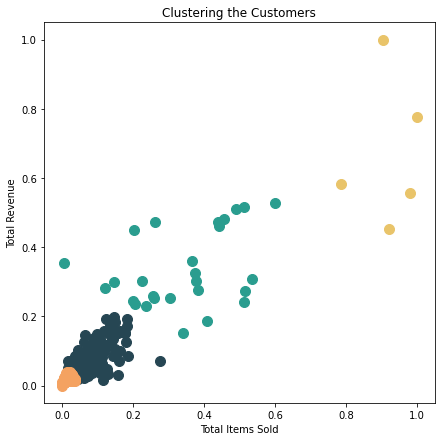

In [ ]:
#Agglomerative Cluster
agg = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
y_agg = agg.fit_predict(points)

fig, axes = plt.subplots(1,1,figsize=(7,7))
plt.scatter(points[y_agg ==0,0], points[y_agg == 0,1], s=100, c='#264653')
plt.scatter(points[y_agg ==1,0], points[y_agg == 1,1], s=100, c='#2a9d8f')
plt.scatter(points[y_agg ==2,0], points[y_agg == 2,1], s=100, c='#e9c46a')
plt.scatter(points[y_agg ==3,0], points[y_agg == 3,1], s=100, c='#f4a261')

plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')



In [ ]:
df_clustering["cluster_agg"] = agg.labels_
df_clustering["cluster_km"] = km.labels_
df_clustering.head(10)

,CustomerID,Total_purchases,Total_Revenue,Quantity,Quantity_scaled,Revenue_scaled,cluster_agg,cluster_km
0,17511.0,1074,88138.20,63014,1.000000,0.776465,2,3
1,13694.0,582,62924.10,61808,0.980953,0.557303,2,3
2,14298.0,1640,50862.44,58021,0.921143,0.452462,2,3
3,14156.0,1406,113855.32,57013,0.905223,1.000000,2,3
4,16684.0,280,65920.12,49391,0.784845,0.583344,2,3
5,15311.0,2491,59419.34,37720,0.600518,0.526839,1,1
6,16422.0,378,34311.00,33584,0.535196,0.308596,1,1
7,17404.0,198,30175.82,32320,0.515233,0.272653,1,1
8,16029.0,264,58193.85,32203,0.513385,0.516187,1,1
9,16333.0,45,26626.80,32184,0.513085,0.241804,1,1


Text(0.5, 1.0, 'DBSCAN')

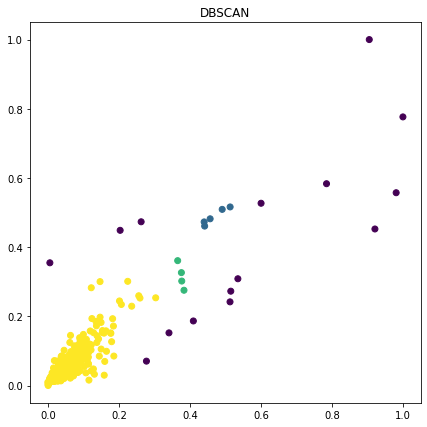

In [ ]:
#let's import a third method: DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.08,min_samples=4)
db.fit(points)
f, axis=plt.subplots(1,1,figsize=(7,7))
y_pred = db.fit_predict(points)
plt.scatter(points[:,0], points[:,1],c=y_pred)
plt.title("DBSCAN")

#DBSCAN algorithm did not work very well this time due to the diferent density of each cluster

